## Testing the Rating System

Let's generate some bernoulli based data based on my soon to be rating model and see if we can recover the parameters via pymc

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm, bernoulli
%matplotlib inline

Generate players and Data

In [15]:
true_team_skill = {
    'A': {
        'A Good': [500, 70],
        'A Decent': [400, 60],
        'A Ok': [350, 40],
        },
    'B': {
        'B Amazing': [600, 50],
        'B Decent': [400, 60],
        'B Bad': [150, 70],
        },
    'C': {
        'C Good': [350, 70],
        'C Good': [350, 70],
        'C Good': [350, 70],
        },
    'D': {
        'D Good': [350, 70],
        'D Inconsistent': [550, 200],
        'D Consistent': [450, 40],
    },
    'E': {
        'E Bad': [250, 70],
        'E Inconsistent': [400, 220],
        'E Bad': [150, 70],
    },
}
beta = 50

num_matches = 300
n_teams = len(true_team_skill)

match_ups = np.random.choice(list(true_team_skill.keys()), (num_matches, 2), p=[0.1, 0.25, 0.25, 0.35, 0.05])
match_ups = match_ups[match_ups[:,0] != match_ups[:,1]]
print("%i Number of Generated Matchups" % len(match_ups))

219 Number of Generated Matchups


In [12]:
winner = []
for match in match_ups:
    team_one = true_team_skill[match[0]]
    team_two = true_team_skill[match[1]]
    
    team_skill_one = np.sum([x[0] for i,x in team_one.items()])
    team_skill_two = np.sum([x[0] for i,x in team_two.items()])
    team_sigma_one = np.sum([x[1]**2 for i,x in team_one.items()])
    team_sigma_two = np.sum([x[1]**2 for i,x in team_two.items()])
    
    break
    p_one = 1.-norm.cdf(0, loc=team_skill_one[0]-team_skill_two[0], scale=np.sqrt(param_one[1]**2 + param_two[1]**2 + beta**2))
    res = bernoulli.rvs(p_one)
    #print('%s vs %s - p: %.1f - %s won' % (match[0], match[1], p_one*100., match[int(np.logical_not(res))]))
    winner.append(match[int(np.logical_not(res))])

In [14]:
np.sqrt(team_sigma_two)

70.710678118654755

In [394]:
obs = pd.DataFrame(match_ups, columns=['Team 1', 'Team 2'])
obs['winner'] = winner
obs.head()

,Team 1,Team 2,winner
0,B,D,B
1,C,B,B
2,D,C,C
3,E,D,E
4,C,B,B


## Non-MCMC Model

In [539]:
from scipy.optimize import minimize

skills_0 = np.array([1000.]*5 + [150.]*5 + [50.])


def loglike(y,p):
    return -1.*(np.sum(y*np.log(p)+(1.-y)*np.log(1-p)))

def obj(skills):
    beta = 50.
    mean_diff = skills[obs['Team 1'].map(mapping).values] - skills[obs['Team 2'].map(mapping).values]
    var_diff = skills[obs['Team 1'].map(mapping).values + 5]**2 + skills[obs['Team 1'].map(mapping).values + 5]**2 + skills[-1]**2
    p = 1.-norm.cdf(0., loc=mean_diff, scale = np.sqrt(var_diff))
    return loglike((obs['Team 1'] == obs['winner']).values, p)


In [540]:
g = minimize(obj, x0=skills_0)

[ 1194.50593627  1098.40564202   891.04213433   942.38666972   873.67666741
   113.60085696   123.5863454    106.54440648    83.18817699   322.02015532
    46.75483377]


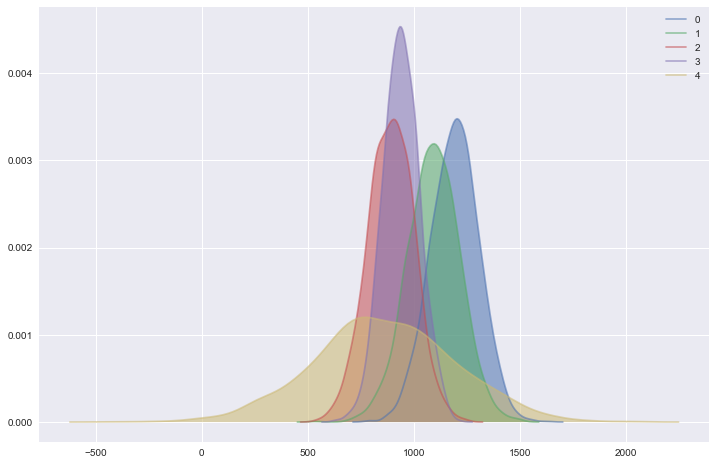

In [541]:
opt_skill = g.x
print(opt_skill)
plots = norm.rvs(opt_skill[:5], opt_skill[5:-1], size=(2000,5))

f, ax = plt.subplots(figsize=(12,8))
[sns.kdeplot(plots[:,i], shade=True, alpha=0.55, legend=True, ax=ax, label=i) for i in range(5)]

In [548]:
infer_mean = opt_skill[:5]
infer_std = opt_skill[5:-1]
infer_beta = opt_skill[-1]

err = {'mcmc': [], 'opt': []}
for pair, k in obs.groupby(['Team 1', 'Team 2']).count().itertuples():
    param_one = true_team_skill[pair[0]]
    param_two = true_team_skill[pair[1]]
    
    p_one_true = 1.-norm.cdf(0, loc=param_one[0]-param_two[0], scale=np.sqrt(param_one[1]**2 + param_two[1]**2 + 50.**2))
    p_one_opt = 1.-norm.cdf(0, loc=infer_mean[mapping[pair[0]]]-infer_mean[mapping[pair[1]]], scale=np.sqrt(infer_std[mapping[pair[0]]]**2 + infer_std[mapping[pair[1]]]**2 + infer_beta**2))
    p_one_mcmc = (1./(1+np.exp(-0.005*(trace['rating'][:,mapping[pair[0]]] - trace['rating'][:,mapping[pair[1]]])))).mean()
    
    err['mcmc'].append(p_one_true-p_one_mcmc); err['opt'].append(p_one_true-p_one_opt);
    
    print('%s vs %s : true - %.2f pct   |   optim - %.2f pct   |   mcmc - %.2f pct' % 
          (pair[0], pair[1], p_one_true*100., p_one_opt*100., p_one_mcmc*100.))

A vs B : true - 66.87 pct   |   optim - 70.94 pct   |   mcmc - 67.31 pct
A vs C : true - 99.62 pct   |   optim - 96.90 pct   |   mcmc - 92.87 pct
A vs D : true - 98.36 pct   |   optim - 95.54 pct   |   mcmc - 89.55 pct
A vs E : true - 83.54 pct   |   optim - 82.40 pct   |   mcmc - 91.68 pct
B vs A : true - 33.13 pct   |   optim - 29.06 pct   |   mcmc - 32.69 pct
B vs C : true - 90.48 pct   |   optim - 88.91 pct   |   mcmc - 86.32 pct
B vs D : true - 85.27 pct   |   optim - 84.12 pct   |   mcmc - 80.59 pct
B vs E : true - 77.02 pct   |   optim - 74.07 pct   |   mcmc - 84.26 pct
C vs A : true - 0.38 pct   |   optim - 3.10 pct   |   mcmc - 7.13 pct
C vs B : true - 9.52 pct   |   optim - 11.09 pct   |   mcmc - 13.68 pct
C vs D : true - 38.02 pct   |   optim - 35.98 pct   |   mcmc - 39.81 pct
C vs E : true - 57.74 pct   |   optim - 52.02 pct   |   mcmc - 46.16 pct
D vs A : true - 1.64 pct   |   optim - 4.46 pct   |   mcmc - 10.45 pct
D vs B : true - 14.73 pct   |   optim - 15.88 pct   |   m

In [549]:
np.mean(np.power(err['mcmc'],2))

0.0044335779687110447

In [550]:
np.mean(np.power(err['opt'],2))

0.00093468368325839882

## Pymc Modelling

In [533]:
import pymc3 as pm
import theano.tensor as tt

In [534]:
mapping = {v:k for k,v in dict(enumerate(['A', 'B', 'C', 'D', 'E'])).items()}
with pm.Model() as rating_model:
    
    #beta = pm.Normal('beta', 50., 10.)
    skills = pm.Normal('rating', 1000., 150., shape=n_teams)
    performance = pm.Normal('performance', skills, 50., shape=n_teams)    
    
    diff = performance[obs['Team 1'].map(mapping).values] - performance[obs['Team 2'].map(mapping).values]
    p = tt.nnet.sigmoid(0.005*diff)
    
    err = pm.DensityDist('observed', lambda x: tt.sum(x*tt.log(p)+(1.-x)*tt.log(1-p)), observed=(obs['Team 1'] == obs['winner']).values)
    #err = pm.Bernoulli('observed', p=p, observed=(obs['Team 1'] == obs['winner']).values)

In [535]:
with rating_model:
    #start = pm.find_MAP()
    trace = pm.sample(10000, tune=0) #step=pm.Metropolis(), start=start, 

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 538.79:   5%|▌          | 9807/200000 [00:03<01:44, 1824.27it/s]
Convergence archived at 9900
Interrupted at 9,900 [4%]: Average Loss = 546.64
100%|████████████████████████████████████▉| 9998/10000 [06:07<00:00, 18.40it/s]C:\Users\Kevin.Pei\AppData\Local\Continuum\Anaconda3\envs\main\lib\site-packages\pymc3\step_methods\hmc\nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.997885983875, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|████████████████████████████████████| 10000/10000 [06:07<00:00, 27.23it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000004D1EB6D8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000000522EAC88>], dtype=object)

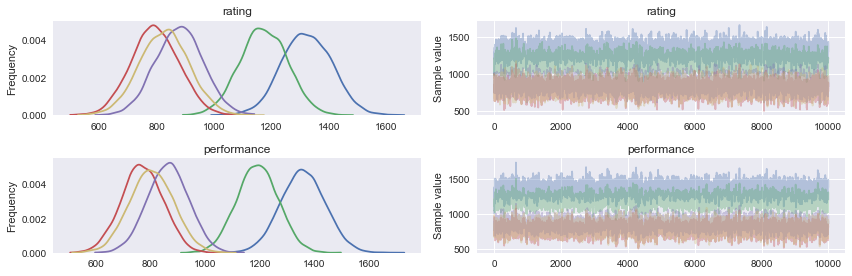

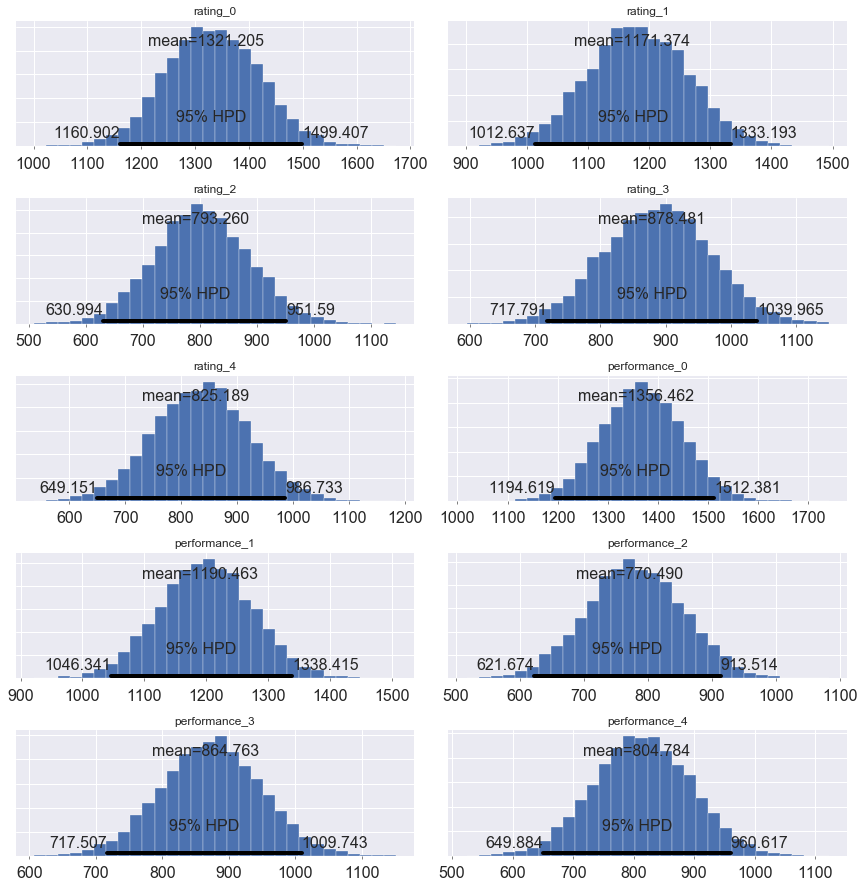

In [536]:
pm.traceplot(trace)
pm.plot_posterior(trace)

In [538]:
infer_mean = trace['rating'].mean(axis=0)
infer_std = trace['rating'].std(axis=0)
for pair, k in obs.groupby(['Team 1', 'Team 2']).count().itertuples():
    param_one = true_team_skill[pair[0]]
    param_two = true_team_skill[pair[1]]
    
    p_one_true = 1.-norm.cdf(0, loc=param_one[0]-param_two[0], scale=np.sqrt(param_one[1]**2 + param_two[1]**2 + beta**2))
    p_one_infer = (1./(1+np.exp(-0.005*(trace['rating'][:,mapping[pair[0]]] - trace['rating'][:,mapping[pair[1]]])))).mean()
    #p_one_infer = 1.-norm.cdf(0, loc=infer_one[0]-infer_two[0], scale=np.sqrt(infer_one[1]**2 + infer_two[1]**2 + 50.**2))
    print('%s vs %s : true - %.2f pct   |   infer - %.2f pct' % (pair[0], pair[1], p_one_true*100., p_one_infer*100.))

A vs B : true - 66.87 pct   |   infer - 67.31 pct
A vs C : true - 99.62 pct   |   infer - 92.87 pct
A vs D : true - 98.36 pct   |   infer - 89.55 pct
A vs E : true - 83.54 pct   |   infer - 91.68 pct
B vs A : true - 33.13 pct   |   infer - 32.69 pct
B vs C : true - 90.48 pct   |   infer - 86.32 pct
B vs D : true - 85.27 pct   |   infer - 80.59 pct
B vs E : true - 77.02 pct   |   infer - 84.26 pct
C vs A : true - 0.38 pct   |   infer - 7.13 pct
C vs B : true - 9.52 pct   |   infer - 13.68 pct
C vs D : true - 38.02 pct   |   infer - 39.81 pct
C vs E : true - 57.74 pct   |   infer - 46.16 pct
D vs A : true - 1.64 pct   |   infer - 10.45 pct
D vs B : true - 14.73 pct   |   infer - 19.41 pct
D vs C : true - 61.98 pct   |   infer - 60.19 pct
D vs E : true - 61.42 pct   |   infer - 56.39 pct
E vs A : true - 16.46 pct   |   infer - 8.32 pct
E vs B : true - 22.98 pct   |   infer - 15.74 pct
E vs C : true - 42.26 pct   |   infer - 53.84 pct
E vs D : true - 38.58 pct   |   infer - 43.61 pct
